In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import sys
sys.path.append('/Users/vsriniv/Documents/Research/Github/PatchSim')
import patchsim as sim
import matplotlib.ticker as plticker
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import hyperopt
from hyperopt import hp, Trials
from tqdm import tqdm

In [3]:
def run_patchsim(x):
    prep_param_file(x)
    stages = 3
    for s in range(stages):
        cfg = sim.read_config('../data/patchsim/calib_cps/cfg_stage{}.txt'.format(s))
        sim.run_disease_simulation(cfg,write_epi=True)

    out_df = pd.DataFrame()
    for s in range(stages):
        temp_df = pd.read_csv('../outputs/sample{}.out'.format(s),delimiter=' ',header=None,index_col=0)       
        if s==0:
            out_df = temp_df.copy(deep=True)
        else:
            temp_df.columns = [x+len(out_df.columns) for x in temp_df.columns]
            out_df = out_df.join(temp_df)
    return out_df

In [4]:
def prep_param_file(x):
    stages = 3
    param_df = pd.DataFrame()
    for s in range(stages):
        temp = pd.read_csv('../data/patchsim/calib_cps/param_stage{}.txt'.format(s),delim_whitespace=True)
        temp['stage'] = s
        param_df = param_df.append(temp)

    param_df['beta'] = param_df.apply(lambda row: get_param(row['id'],row['stage'],x),axis=1)
    for s in range(stages):
        param_df[param_df.stage==s][['id','beta','alpha','gamma']].to_csv('../data/patchsim/calib_cps/param_stage{}.txt'.format(s),sep=' ',index=None)
    return

In [5]:
gt = pd.read_csv('../data/Ebola_Updated_Feb18.csv', delimiter='\t')
gt['Date'] = gt.date.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
gt['Ob_Day'] = gt.Date.apply(lambda x : (x - datetime.strptime('20180805','%Y%m%d')).days)
gt = gt[gt.Date>=datetime.strptime('20180805','%Y%m%d')] ## Starting on August 5th, the first non-NaN value

key_hzs = gt[gt.Date==gt.Date.max()][['health_zone','total_c']].sort_values('total_c',ascending=False).head(7)['health_zone'].values
key_hzs = sorted(list(set(key_hzs) - {'all'}))

T = len(gt[gt.health_zone=='all'])

In [6]:
def drc_error_func(out_df,w):
    y_hat = out_df.sum().cumsum().values
    y = gt[gt.health_zone=='all']['total_c'].values

    diff = np.abs(y_hat-y)
    disc_wt = [w**(len(diff)-1-x) for x in range(len(diff))] 

    return sum(disc_wt*diff)

In [7]:
def hz_error_func(out_df,w):
    calib_key_hzs = ['Mabalako','Beni','Butembo','Katwa']
    y_hat = out_df.loc[[k.upper() for k in calib_key_hzs]].cumsum(axis=1).values
    y = gt.pivot(index='health_zone',columns='Ob_Day',values='total_c').loc[calib_key_hzs].fillna(0).values

    diff = sum(np.abs(y_hat-y))
    disc_wt = [w**(len(diff)-1-x) for x in range(len(diff))]
    
    return sum(disc_wt*diff)

In [8]:
def agg_error_func(x):
    w = 0.75
    drc_wt = 0
    hz_wt = 1
    
    out_df = run_patchsim(x)
    
    drc_err = drc_error_func(out_df,w)
    hz_err = hz_error_func(out_df,w)
    
    pbar.update()
    return drc_wt*drc_err + hz_wt*hz_err

In [9]:
def get_param(hz,stage,x):
    ## x = [0.250, 0.210, 0.125, 0.070, 0.210]  - Manual parameters
    if (hz=='MABALAKO') & (stage==0): return x[0]       
    if (hz=='BENI') & (stage<=1): return x[1]    
    if (hz in ['BUTEMBO','KATWA']) & (stage==1): return x[2]
    if (hz=='BENI') & (stage==2): return x[3]
    if (hz=='KATWA') & (stage==2): return x[4]
    return 

In [10]:
column_labels = ['mab_s0','beni_s01','butkat_s1','beni_s2','kat_s2']
x_space = [hp.uniform('0',0.24,0.26),
           hp.uniform('1',0.20,0.22),
           hp.uniform('2',0.11,0.14),
           hp.uniform('3',0.06,0.08),
           hp.uniform('4',0.20,0.22)]

# x_space = [hp.uniform('0',0.25,0.25),
#            hp.uniform('1',0.21,0.21),
#            hp.uniform('2',0.125,0.125),
#            hp.uniform('3',0.07,0.07),
#            hp.uniform('4',0.21,0.21)]

In [11]:
trials = Trials()
max_evals = 100
pbar = tqdm(total=max_evals, desc="Calibration")
x_opt_dict = hyperopt.fmin(agg_error_func, space=x_space, algo=hyperopt.rand.suggest, max_evals=max_evals, trials=trials)  
particles_df = pd.DataFrame(dict(sorted({int(k):v for k,v in trials.vals.items()}.items())))
particles_df.columns = column_labels
particles_df['loss'] = trials.losses()
pbar.close()

Calibration: 100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


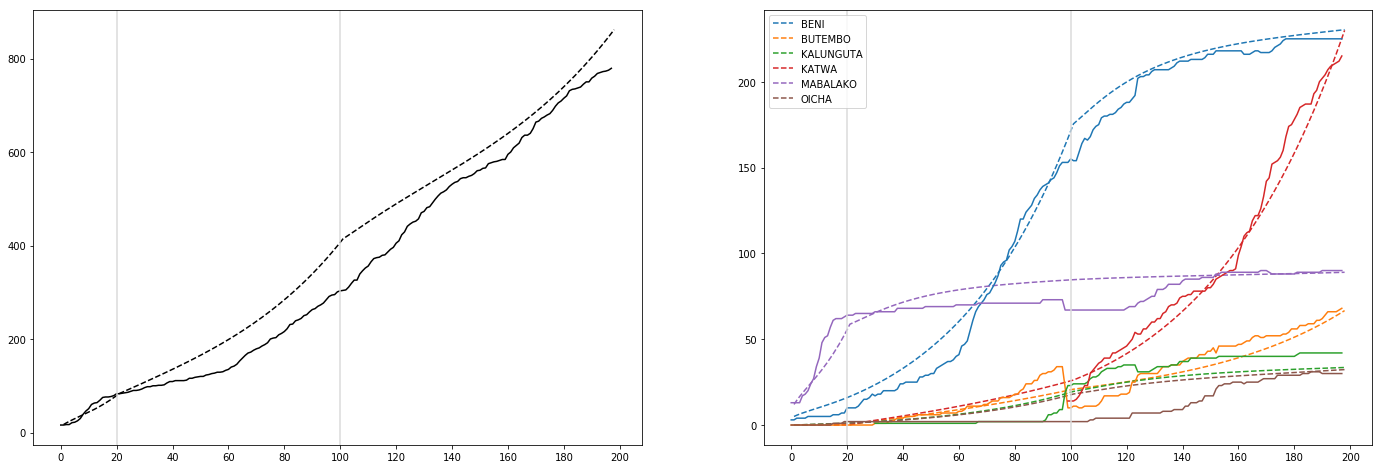

In [12]:
f,axarr = plt.subplots(1,2,figsize=(24,8))

x_opt = [x_opt_dict[str(i)] for i in range(len(x_space))]
out_df = run_patchsim(x_opt)
out_df.sum().cumsum().plot(label='Simulated',ax=axarr[0],color='k',style='--')
axarr[0].plot(gt[gt.health_zone=='all'].total_c.values,label='Ground Truth',color='k')

out_df.loc[[k.upper() for k in key_hzs]].T.cumsum().plot(ax=axarr[1], style='--')
axarr[1].legend().set_title('')
axarr[1].set_prop_cycle(None)
for h in key_hzs:
    gt[gt.health_zone==h.capitalize()].reset_index().plot(y='total_c',ax=axarr[1],legend=None)
    
cp_timings = [20,100,197]    
for t in cp_timings[:-1]:
    axarr[0].axvline(t,color='#dbdbdb')
    axarr[1].axvline(t,color='#dbdbdb')
    
loc = plticker.MultipleLocator(base=20) 
axarr[0].xaxis.set_major_locator(loc)
axarr[1].xaxis.set_major_locator(loc)

In [13]:
particles_df.sort_values('loss').head()

,mab_s0,beni_s01,butkat_s1,beni_s2,kat_s2,loss
87,0.244414,0.211696,0.125231,0.066763,0.209543,68.682185
27,0.240509,0.213169,0.127849,0.066757,0.201595,102.609200
75,0.253778,0.212229,0.121764,0.064543,0.208381,117.650478
78,0.259687,0.212708,0.124187,0.065162,0.205930,118.004399
85,0.257623,0.204687,0.125112,0.079515,0.212018,128.767796
